# 6imilarité group 2

### Introduction

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import zipfile
import random
import torchvision
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict

import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask
import torchvision.models as models

import time
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from typing import Tuple, Dict, Any, List

from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.methods import SmoothGradCAMpp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda
NVIDIA A2


### Download the data

In [2]:
#!pip install kaggle
# Retrive you kaggle credentials inside your kaggle account and put the kaggle.json file inside /home/onyxia/.kaggle/ 
!kaggle datasets download jutrera/stanford-car-dataset-by-classes-folder

Dataset URL: https://www.kaggle.com/datasets/jutrera/stanford-car-dataset-by-classes-folder
License(s): other
stanford-car-dataset-by-classes-folder.zip: Skipping, found more recently modified local copy (use --force to force download)


### Useful variables and functions

In [3]:
DATA_PATH = "data/car_data/car_data/"
TRAIN_PATH = "data/car_data/car_data/train"
VAL_PATH = "data/car_data/car_data/val"
TEST_PATH = "data/car_data/car_data/test"

In [4]:
# Create "data/" directory
def create_dir(directory_path: str) -> None:
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

# Décompresser les données
def unzip_data() -> None:
    with zipfile.ZipFile("stanford-car-dataset-by-classes-folder.zip", "r") as zip_file:
        zip_file.extractall("data/")

# Split the initial test data into the training and validation data
def split_initial_test_folder() -> None:
    for class_folder in os.listdir(TEST_PATH):
        create_dir(os.path.join(VAL_PATH, class_folder))
        
        for i, image_name in enumerate(os.listdir(os.path.join(TEST_PATH, class_folder))):
            if i % 5 == 0: # Move 1/5 of data inside training dataset
                shutil.move(os.path.join(TEST_PATH, class_folder, image_name), os.path.join(TRAIN_PATH, class_folder, image_name))
            elif i % 5 < 3: # Move 2/5 of data inside validation dataset
                shutil.move(os.path.join(TEST_PATH, class_folder, image_name), os.path.join(VAL_PATH, class_folder, image_name))

### Loading and split the data from zip

In [5]:
if os.path.exists(VAL_PATH):
    print("Repartion already exist")
else:
    create_dir("data")
    unzip_data()
    split_initial_test_folder()

Repartion already exist


### Compute the sample repartition

In [6]:
count_train, count_val, count_test = 0, 0, 0
for class_folder in os.listdir(TRAIN_PATH):
    count_train += len(os.listdir(os.path.join(TRAIN_PATH, class_folder)))
for class_folder in os.listdir(VAL_PATH):
    count_val += len(os.listdir(os.path.join(VAL_PATH, class_folder)))
for class_folder in os.listdir(TEST_PATH):
    count_test += len(os.listdir(os.path.join(TEST_PATH, class_folder)))

total = count_train + count_val + count_test
print(f"Total data {total}, train:{round(count_train / total, 2)}, validation: {round(count_val / total, 2)}, test:{round(count_test / total, 2)}")
assert len(os.listdir(TRAIN_PATH)) == len(os.listdir(VAL_PATH)) == len(os.listdir(TEST_PATH))

Total data 16181, train:0.61, validation: 0.2, test:0.19


## Loading and displaying the data

### Plot images

In [7]:
def truncate_string(string: str, max_length: int) -> str:
    if len(string) > max_length:
        return string[:max_length - 3] + " [...]"
    else:
        return string

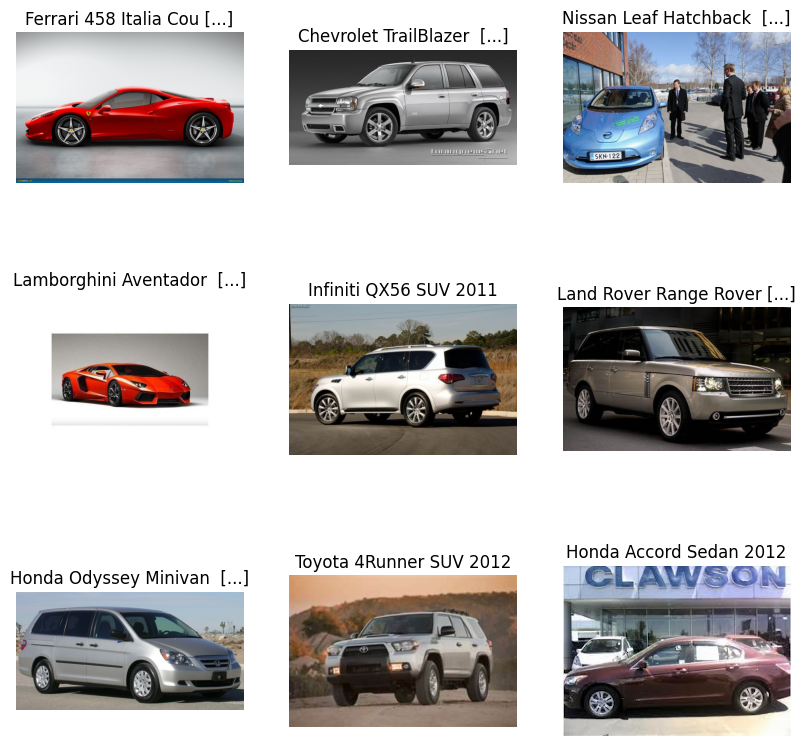

In [8]:
plt.figure(figsize=(10, 10))
classes_directory = random.choices(os.listdir(TRAIN_PATH), k=9)

for i, class_name in enumerate(classes_directory):
    sample_filename = random.choice(os.listdir(os.path.join(TRAIN_PATH, class_name)))
    image_path = os.path.join(TRAIN_PATH, class_name, sample_filename)
    image = Image.open(image_path)
    
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(truncate_string(class_name, 25))
    plt.axis("off")

### Bar Chart of the class weight in training dataset

In [9]:
car_count_dict = {}

for class_folder in os.listdir(TRAIN_PATH):
    count = len(os.listdir(os.path.join(TRAIN_PATH, class_folder)))
    car_count_dict[class_folder] = count

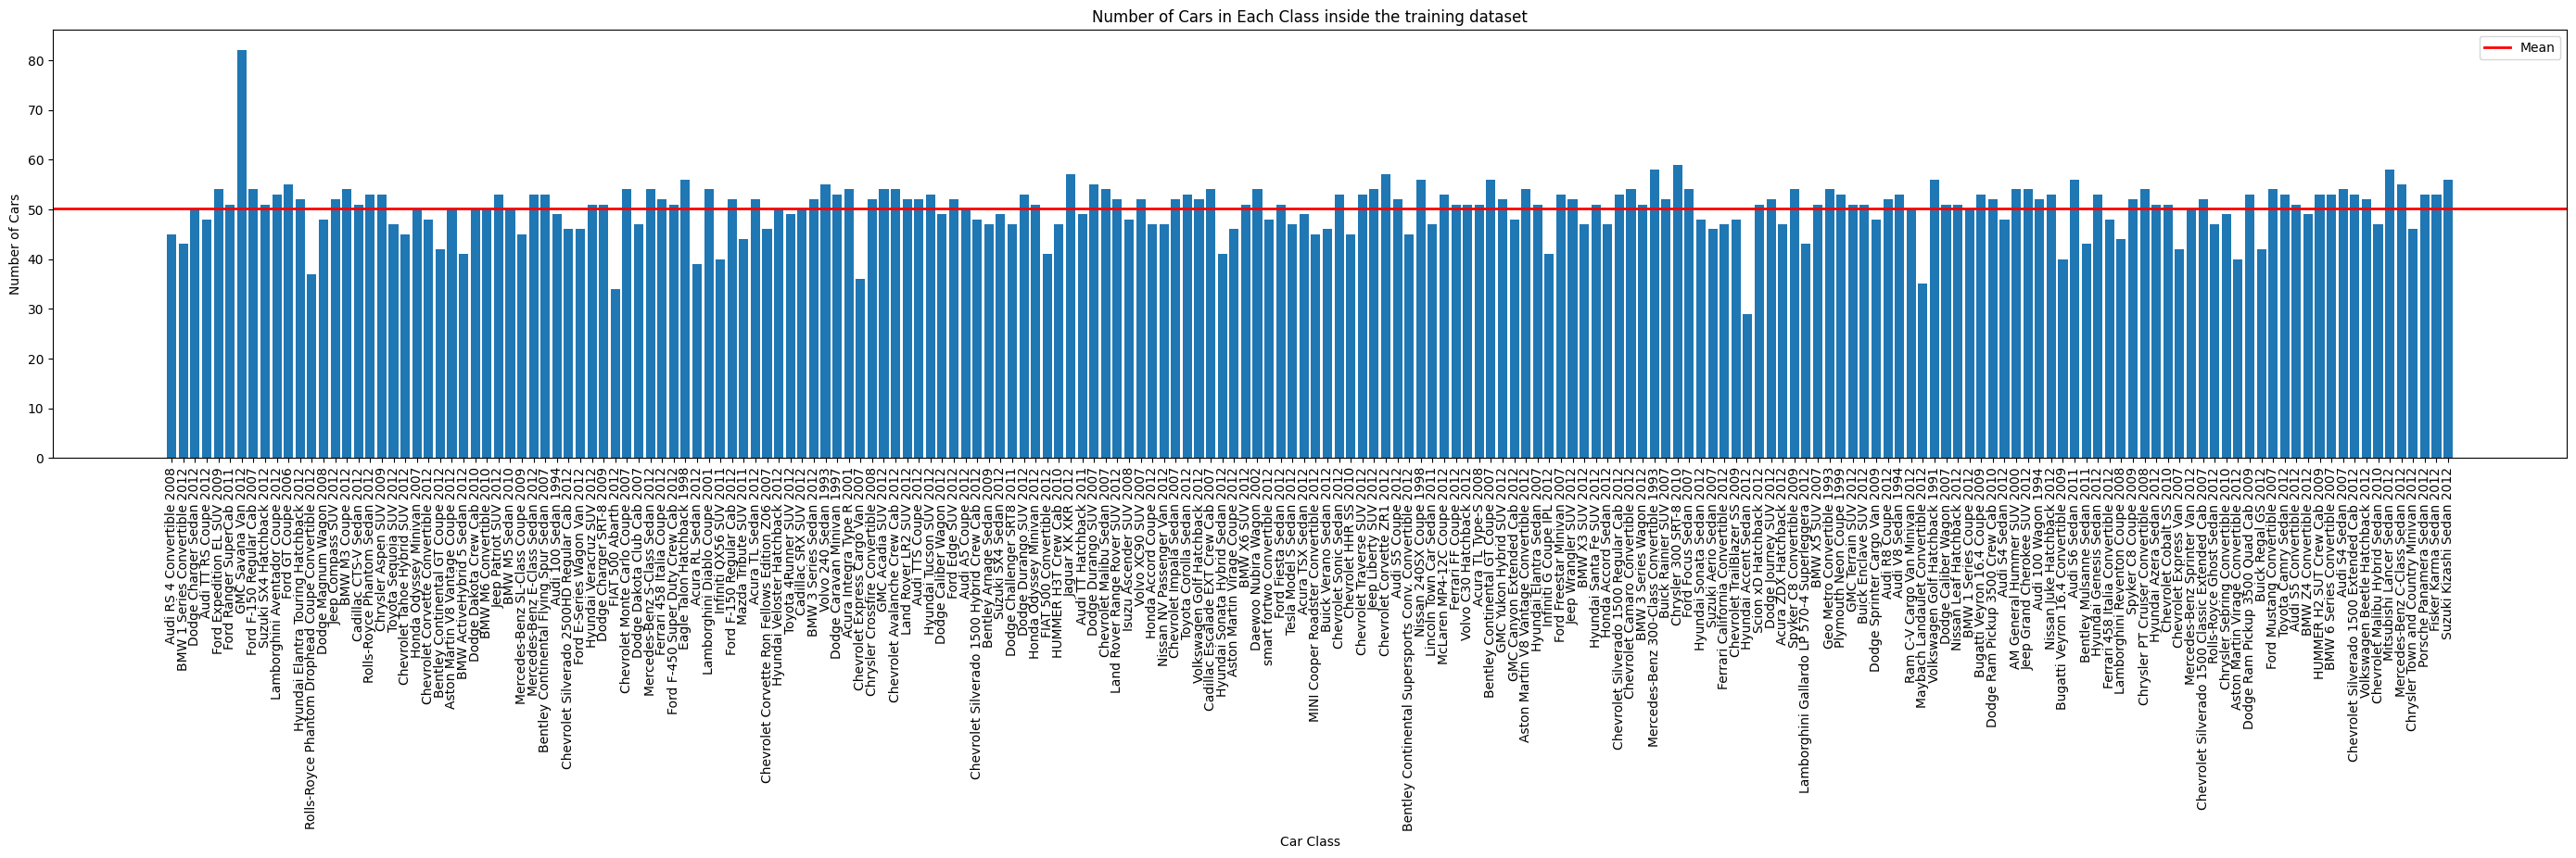

In [10]:
plt.figure(figsize=(35, 6))
plt.bar(car_count_dict.keys(), car_count_dict.values())

plt.xlabel('Car Class')
plt.ylabel('Number of Cars')
plt.title('Number of Cars in Each Class inside the training dataset')

# Calculating the mean of car counts
mean_value = np.mean(list(car_count_dict.values()))
plt.axhline(y=mean_value, color='r', linestyle='-', linewidth=2, label='Mean')
plt.legend()

plt.xticks(rotation=90)
plt.show()

In [11]:
car_count_dict = {}

for class_folder in os.listdir(TEST_PATH):
    count = len(os.listdir(os.path.join(TEST_PATH, class_folder)))
    car_count_dict[class_folder] = count

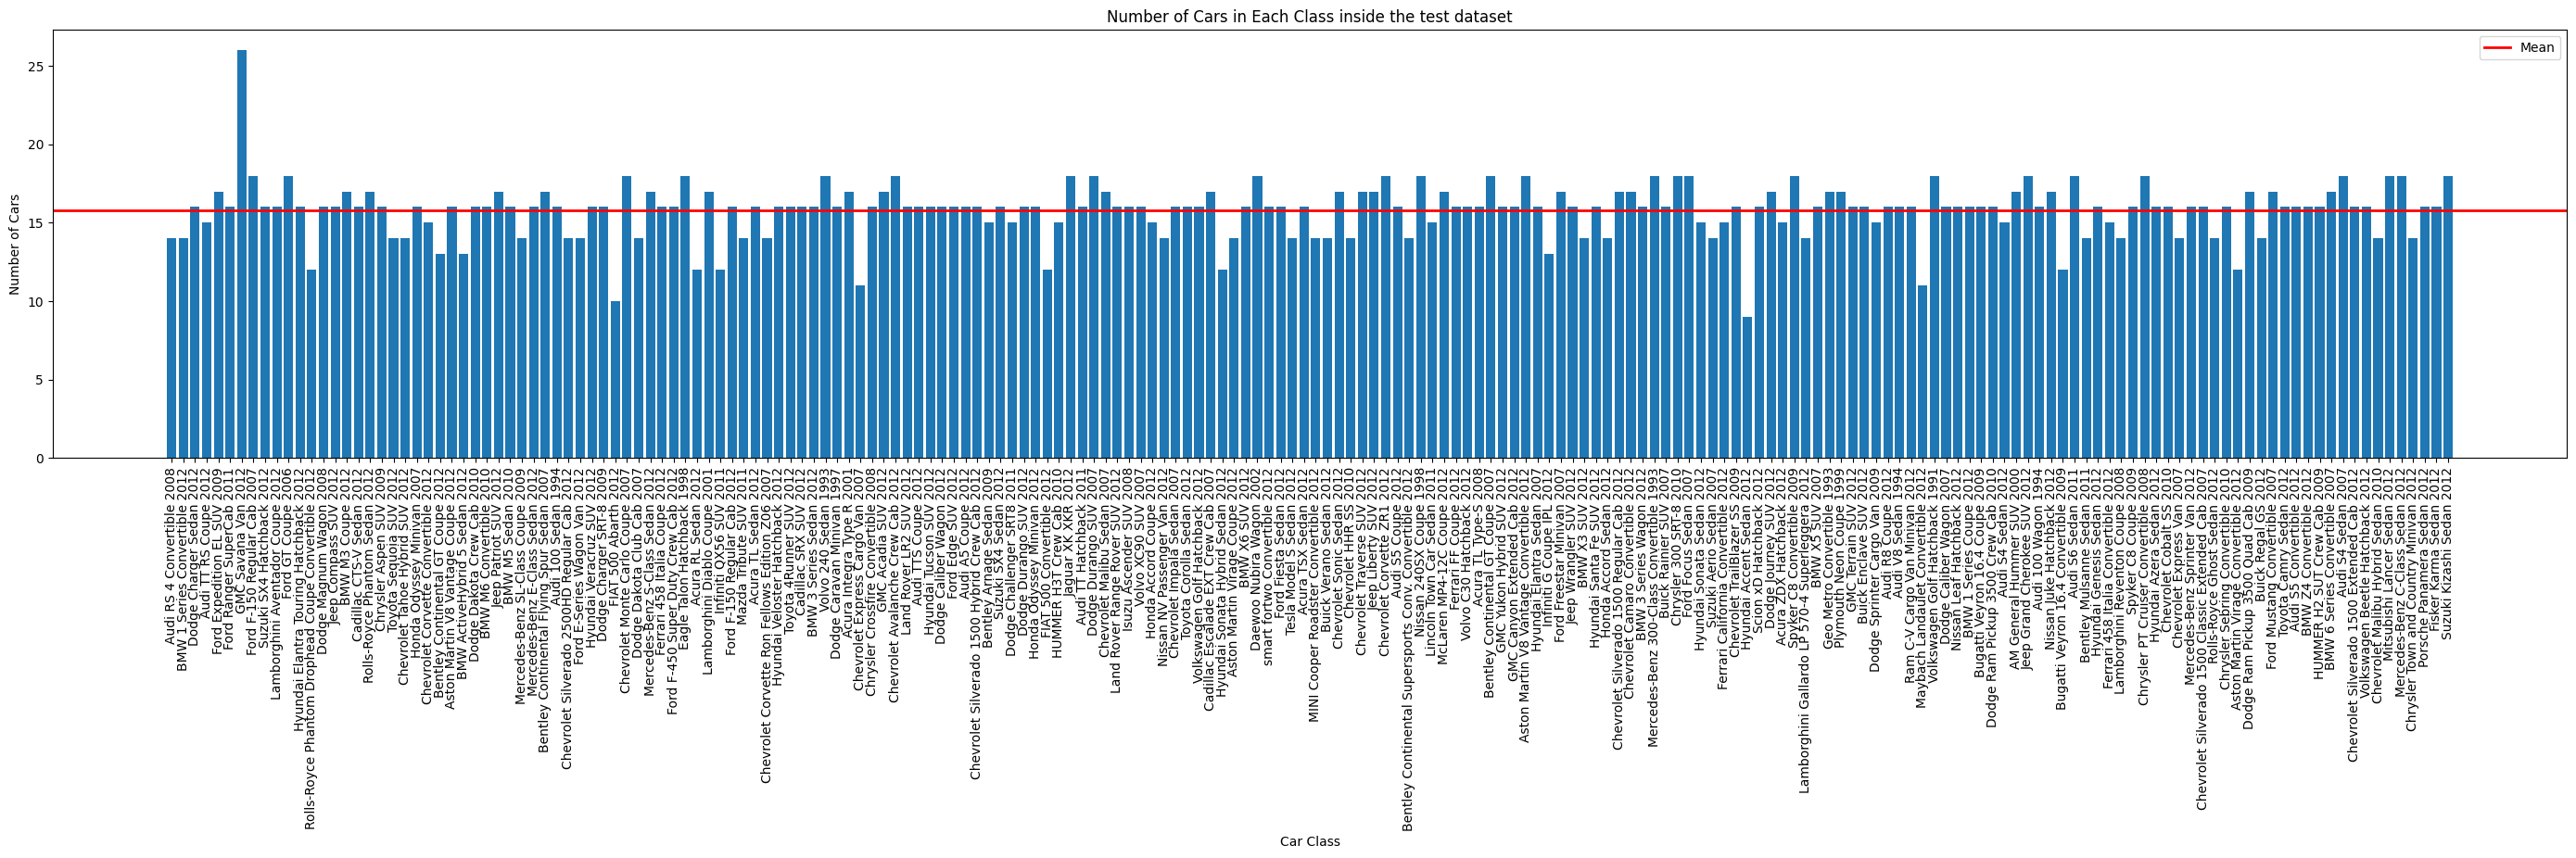

In [12]:
plt.figure(figsize=(35, 6))
plt.bar(car_count_dict.keys(), car_count_dict.values())

plt.xlabel('Car Class')
plt.ylabel('Number of Cars')
plt.title('Number of Cars in Each Class inside the test dataset')

# Calculating the mean of car counts
mean_value = np.mean(list(car_count_dict.values()))
plt.axhline(y=mean_value, color='r', linestyle='-', linewidth=2, label='Mean')
plt.legend()

plt.xticks(rotation=90)
plt.show()

### Get the average size of images in the training Dataset

In [13]:
height, width = [], []
for class_folder in os.listdir(os.path.join(DATA_PATH, 'train')):
    for image_filename in os.listdir(os.path.join(DATA_PATH, 'train', class_folder)):
        image_path = os.path.join(DATA_PATH, 'train', class_folder, image_filename)
        image = Image.open(image_path)
        height.append(image.height)
        width.append(image.width)

mean_height = round(np.mean(np.array(height)))
mean_width = round(np.mean(np.array(width)))

print(f"{mean_width = }, {mean_height = }")

mean_width = 698, mean_height = 482


## Data augmentation

In [14]:
import multiprocessing

num_cores = multiprocessing.cpu_count()
print(f"{num_cores = }")

num_cores = 104


In [15]:
# Imported from ImageNet
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [16]:
# defining the transformation for the dataset
train_augmentation = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

val_train_augmentation = transforms.Compose([transforms.Resize((224, 224)), #400
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

test_train_augmentation = transforms.Compose([transforms.Resize((224, 224)), #400
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

In [17]:
BATCH_SIZE = 32

train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform = train_augmentation)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers = num_cores)

val_dataset = torchvision.datasets.ImageFolder(root=TEST_PATH, transform = val_train_augmentation)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle=False, num_workers = num_cores)

test_dataset = torchvision.datasets.ImageFolder(root=TEST_PATH, transform = test_train_augmentation)

# Create a dictionary to associate image indices with image path
image_index_to_path = defaultdict(str)
for i, (image, _) in enumerate(test_dataset):
    image_path = test_dataset.imgs[i][0]
    image_index_to_path[i] = image_path

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False, num_workers = num_cores)

### Creating the model

In [18]:
model = models.resnet18(progress=True, pretrained=True)

num_ftrs = model.fc.in_features
no_classes = len(train_dataset.classes)

# Adapt the last dense layer for the 200 avalaible classes
model.fc = nn.Linear(num_ftrs, no_classes)

/opt/mamba/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Display thee model architecture

In [19]:
model.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


### Compute Class weights

In [20]:
# Transform string labels into int labels
counter = 0
label_to_int = {}

for class_name in os.listdir(TRAIN_PATH):
    label_to_int[class_name] = counter
    counter += 1

sample_to_int = []
for class_folder in os.listdir(TRAIN_PATH):
    for _ in os.listdir(os.path.join(TRAIN_PATH, class_folder)):
        sample_to_int.append(label_to_int[class_folder])

y = np.array(sample_to_int)

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)

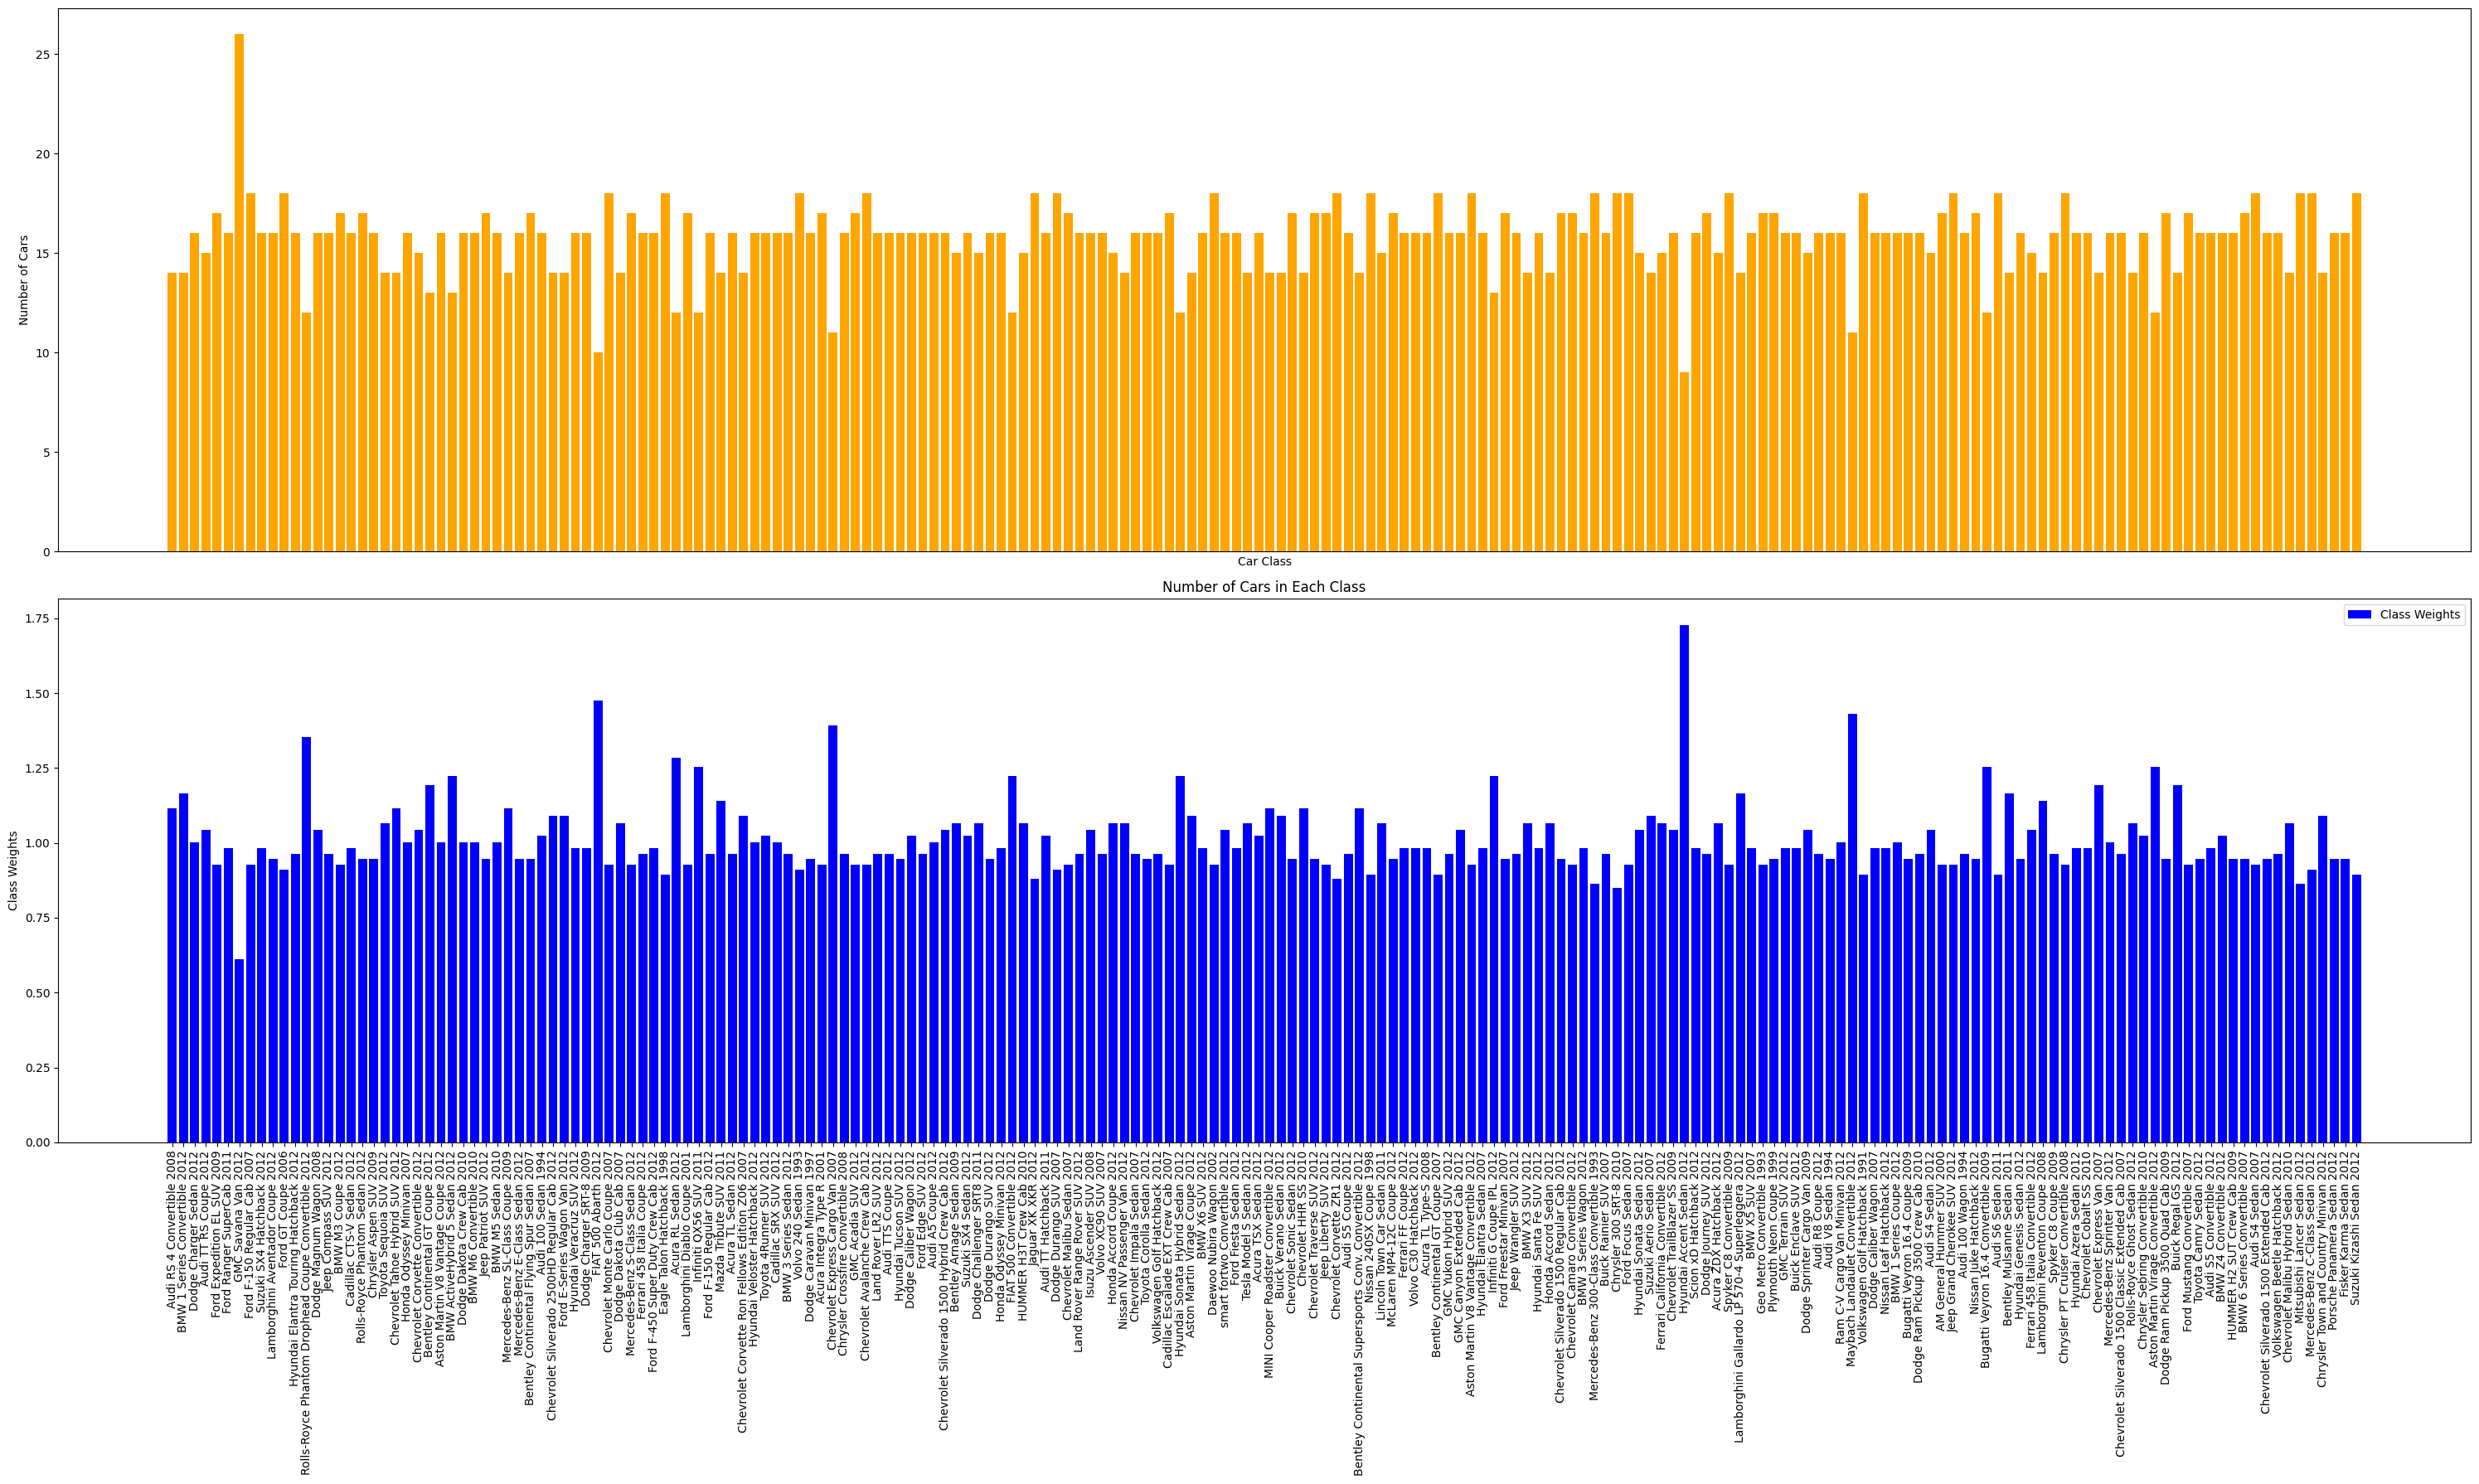

In [21]:
# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 18))

# Plot the first bar graph on the first subplot (top)
ax1.bar(car_count_dict.keys(), car_count_dict.values(), color='orange', label='Car Count')
ax1.set_xlabel('Car Class')
ax1.set_ylabel('Number of Cars')
ax1.set_xticks([])

# Plot the second bar graph on the second subplot (bottom)
ax2.bar(car_count_dict.keys(), class_weights, color='blue', label='Class Weights')
ax2.set_ylabel('Class Weights')
ax2.set_title('Number of Cars in Each Class')
ax2.legend()

# Rotate x-axis labels for better visibility
plt.setp(ax2.get_xticklabels(), rotation=90)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

### Setting the Hyper-Parameters 

In [22]:
model = model.to(device)

# Defining the loss function and the optimizer
class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.02)
optimizer = optim.Adam(model.parameters(), weight_decay=5e-5) # weight_decay == L2 (riddge)

In [23]:
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1, patience=2, min_lr=0.00001, verbose=True)

/opt/mamba/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


## Training the model

In [24]:
# Evaluate the model via the test dataset and generate predictions.
def eval_model(model: nn.Module, val_loader: torch.utils.data.DataLoader,
               device: torch.device) -> Tuple[float, float]:
    correct = 0.0
    total = 0.0
    running_loss = 0.0

    # Set the model to eval
    model.eval()
    
    # Forward propagation only (no training on test dataset)
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            images, labels = data
            
            # Transfer to GPU
            images = images.to(device)
            labels = labels.to(device)

            # Forward propagation
            outputs = model(images)
            
            # Get predictions from the maximum value 
            _, predicted = torch.max(outputs.data, 1)

            # Calculate the loss
            loss = criterion(outputs, labels)
            
            # Total number of labels in the test data set
            total += labels.size(0)
            
            # Total correct predictions
            running_loss += loss.item()
            correct += (predicted == labels).sum().item()
    
    # Calculate the accuracy
    test_accuracy = correct / (BATCH_SIZE * len(test_loader))
    test_loss = running_loss / len(test_loader)
    return test_accuracy, test_loss

In [25]:
def train_model(model: nn.Module, train_loader: torch.utils.data.DataLoader, val_loader: torch.utils.data.DataLoader,
                criterion: nn.Module, optimizer: optim.Optimizer, scheduler: optim.lr_scheduler.ReduceLROnPlateau,
                device: torch.device, n_epochs: int = 5) -> Dict[str, List[float]]:
    
    history: Dict[str, List[float]] = {
        "losses": [],
        "accuracies": [],
        "test_accuracies": [],
        "test_losses": [],
        "lr": []
    }

    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0

        # set the model to train mode initially
        # (This is important as some models behave differently in train and test time.)
        model.train()

        with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch + 1}") as training_epoch:
            for i, data in enumerate(training_epoch):
                inputs, labels = data

                # Transfer to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward propagation
                outputs = model(inputs)
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Calculate the loss
                loss = criterion(outputs, labels)
                
                # Backward pass
                loss.backward()
                # Optimize the weights
                optimizer.step()
                
                # Calculate the loss and The accuracy
                running_loss += loss.item()
                running_correct += (labels==predicted).sum().item()
        
        # Compute and appen metric values
        epoch_acc = running_correct / (BATCH_SIZE * len(train_loader))
        epoch_loss = running_loss / len(train_loader)

        history['losses'].append(epoch_loss)
        history['accuracies'].append(epoch_acc)
                
        test_acc, test_loss = eval_model(model, val_loader, device)
        history['test_accuracies'].append(test_acc)
        history['test_losses'].append(test_loss)
        history['lr'].append(optimizer.state_dict()['param_groups'][0]['lr'])

        # Print the data
        print("Epoch %s: duration: %d s, acc: %.4f, loss: %.4f, val_acc: %.4f, val_loss: %.4f, lr: %.6f"
            % (epoch + 1, time.time() - since, epoch_acc, epoch_loss, test_acc, test_loss, history['lr'][-1])
        )
        
        # Adapt the learning rate if needed
        scheduler.step(test_loss)
        
    print('Finished Training')
    return history

In [26]:
NEPOCHS = 0

# Train the model
history = train_model(
    model,
    train_loader, 
    val_loader,
    criterion,
    optimizer,
    lrscheduler,
    device,
    n_epochs=NEPOCHS
)

Finished Training


In [27]:
# Load model architecture
model = torch.load('save/model.pth')

# Create a new instance of the same model architecture
# For example, if you're using a custom model class:
# model = MyModelClass()

# Load the trained parameters (state_dict) into the model
model.load_state_dict(torch.load('save/model_state_dict.pth'))

<All keys matched successfully>

In [28]:
# Save model's Architecture
#torch.save(model, 'save/model.pth')

# Save model's state_dict
#torch.save(model.state_dict(), 'save/model_state_dict.pth')

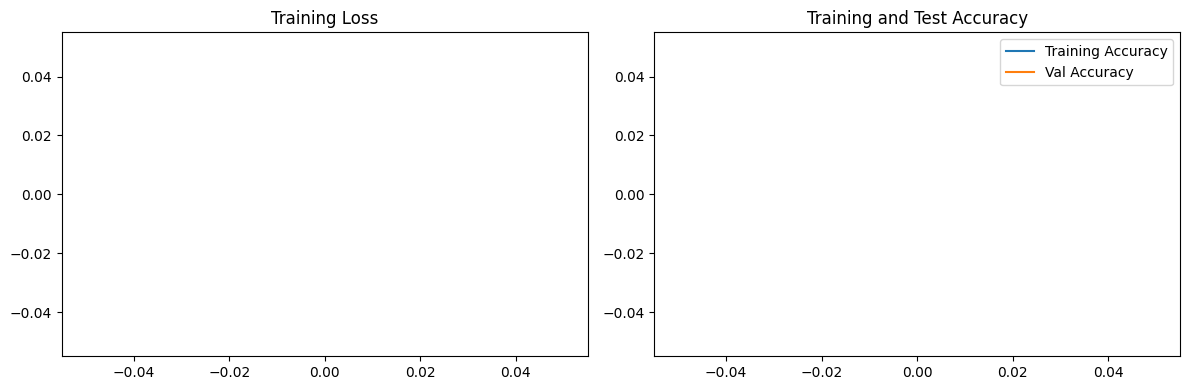

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot training loss
axs[0].plot(history["losses"], label="Training Losses")
axs[0].plot(history["test_losses"], label="Val Losses")
axs[0].set_title("Training Loss")

# Plot training and test accuracy
axs[1].plot(history["accuracies"], label="Training Accuracy")
axs[1].plot(history["test_accuracies"], label="Val Accuracy")
axs[1].set_title("Training and Test Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

In [30]:
import torch.nn.functional as F

# Set the model to evaluation mode
model.eval()

# Define empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []
predicted_probs = []

# Iterate over the test dataset to make predictions
for images, labels in test_loader:
    # Transfer to GPU
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = model(images)
    probs, predicted = torch.max(outputs, 1)
    
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())
    predicted_probs.extend(probs.cpu().detach().numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the accuracy
correct_predictions = np.sum(np.diag(conf_matrix))
total_predictions = np.sum(conf_matrix)

print("Final accuracy on the test dataset")
print(correct_predictions / total_predictions)

Final accuracy on the test dataset
0.8338182993857096


In [64]:
import numpy as np

# Find incorrect predictions and their corresponding probabilities
incorrect_predictions = []
for i, (true_label, predicted_label, prob) in enumerate(zip(true_labels, predicted_labels, predicted_probs)):
    if true_label != predicted_label:
        incorrect_predictions.append((i, true_label, predicted_label, prob))

# Sort the incorrect predictions based on prediction confidence (probability)
incorrect_predictions.sort(key=lambda x: x[3])

# Get the 9 samples with the worst loss predictions
print("Samples with the worst predictions:")
input_path = []

for i in range(9):
    index, true_label, predicted_label, prob = incorrect_predictions[i]
    input_path.append(image_index_to_path[index])
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}, Probability: {prob}")

Samples with the worst predictions:
True Label: 14, Predicted Label: 134, Probability: -3.5647130012512207
True Label: 181, Predicted Label: 75, Probability: -3.433424949645996
True Label: 172, Predicted Label: 33, Probability: -3.3256657123565674
True Label: 33, Predicted Label: 179, Probability: -3.087749481201172
True Label: 190, Predicted Label: 90, Probability: -2.850886344909668
True Label: 40, Predicted Label: 166, Probability: -2.842397689819336
True Label: 164, Predicted Label: 58, Probability: -2.787026882171631
True Label: 24, Predicted Label: 11, Probability: -2.6836438179016113
True Label: 108, Predicted Label: 38, Probability: -2.436124801635742


In [65]:
activation_map = []
images_map = []
with SmoothGradCAMpp(model) as cam_extractor:
    for error_path in input_path:
        img = read_image(error_path)
        input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        input_tensor = input_tensor.to(device)
        out = model(input_tensor.unsqueeze(0))
        
        # Retrieve the CAM by passing the class index and the model output
        images_map.append(img)
        activation_map.append(cam_extractor(out.squeeze(0).argmax().item(), out))

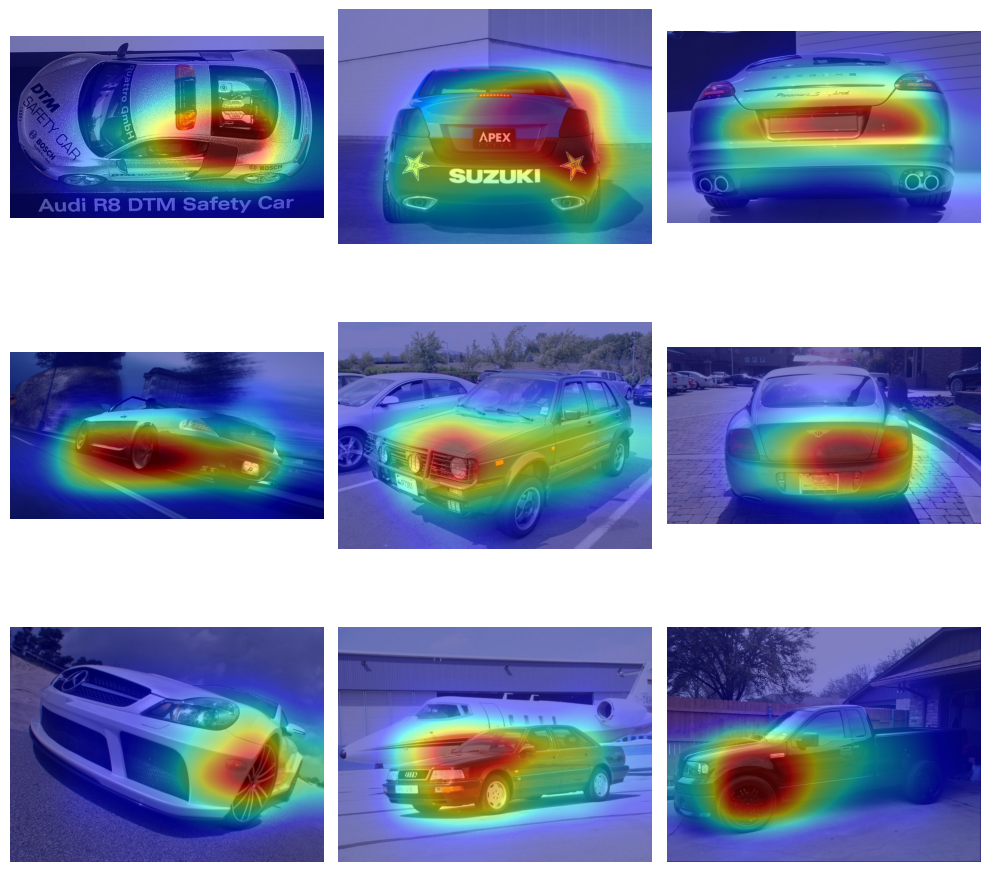

In [66]:
# Display each image on a subplot
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, (img, act_map) in enumerate(zip(images_map, activation_map)):
    result = overlay_mask(to_pil_image(img), to_pil_image(act_map[0].squeeze(0), mode='F'), alpha=0.5)
    
    ax = axes[i // 3, i % 3]
    ax.imshow(result)
    ax.axis('off')

plt.tight_layout()
plt.show()

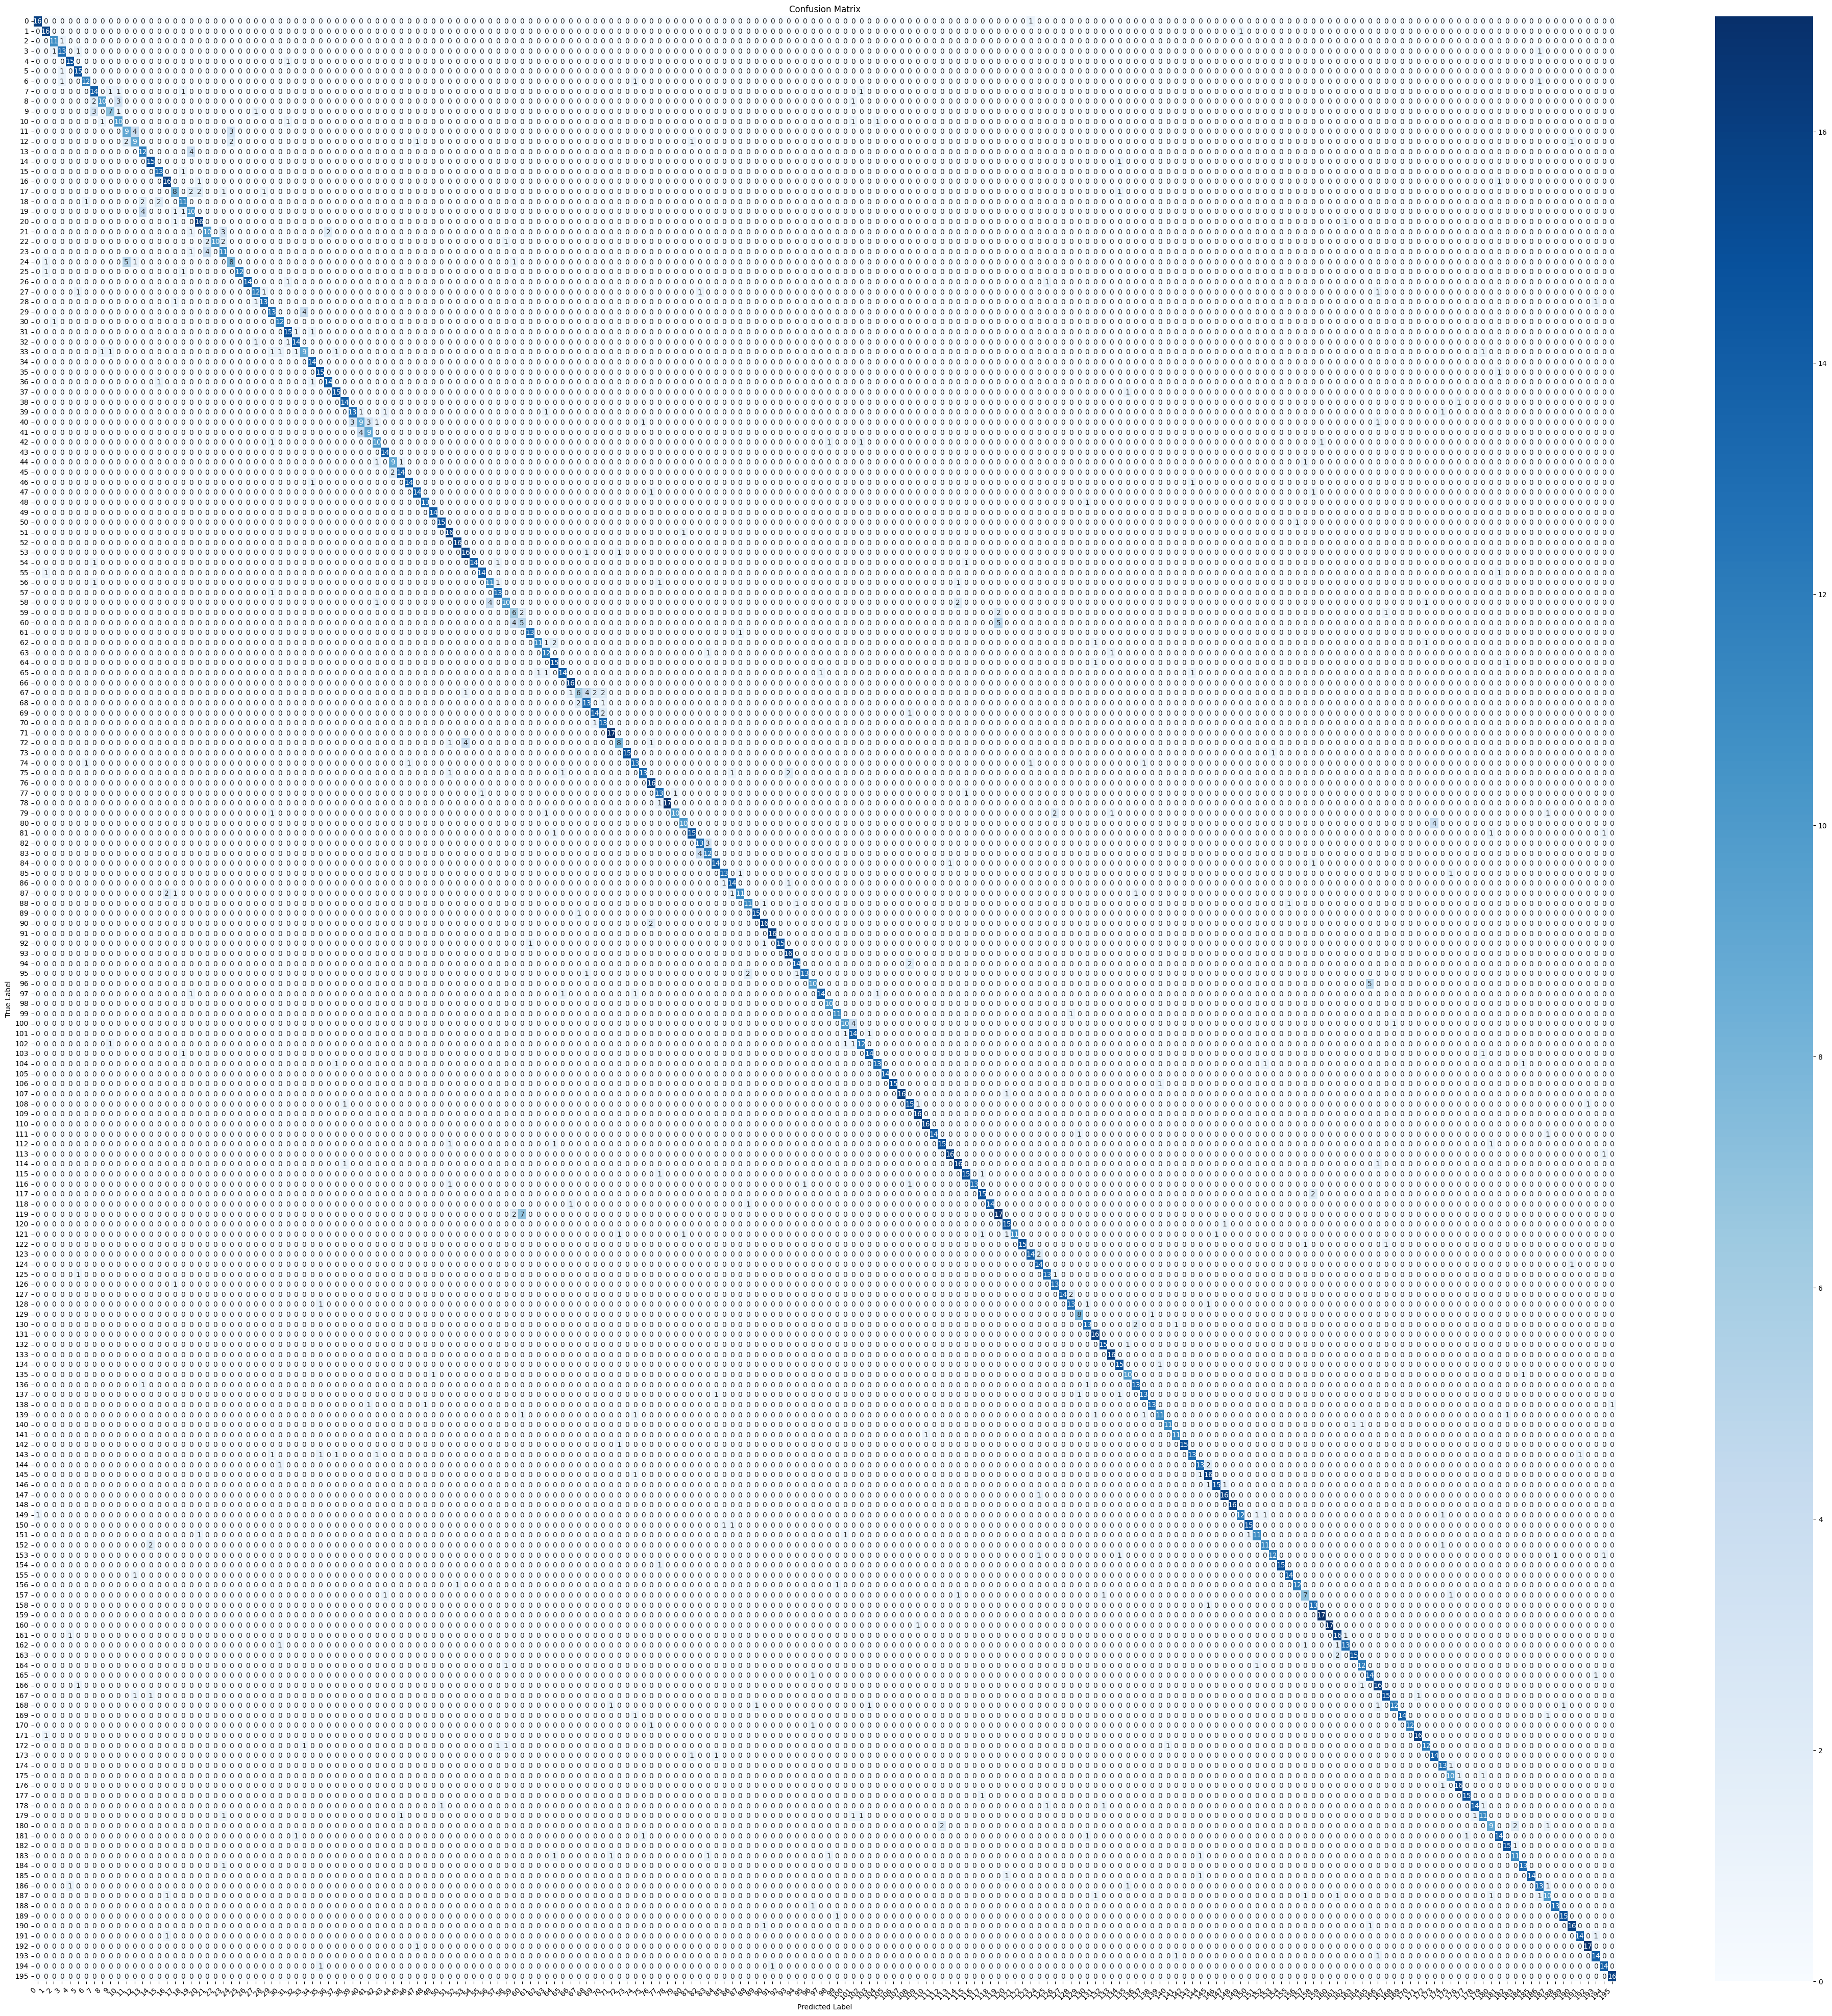

In [67]:
# Define the class labels
class_labels = [str(i) for i in range(len(conf_matrix))]

# Create a heatmap for the confusion matrix
plt.figure(figsize=(50, 50))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Rotate the tick labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()

In [68]:
# Compute the classification report
cr = classification_report(true_labels, predicted_labels)
print(cr)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        17
           1       0.80      0.94      0.86        17
           2       0.85      0.92      0.88        12
           3       0.81      0.81      0.81        16
           4       0.88      0.94      0.91        16
           5       0.79      0.94      0.86        16
           6       0.86      0.80      0.83        15
           7       0.67      0.78      0.72        18
           8       0.83      0.62      0.71        16
           9       0.70      0.58      0.64        12
          10       0.67      0.71      0.69        14
          11       0.56      0.56      0.56        16
          12       0.56      0.56      0.56        16
          13       0.63      0.75      0.69        16
          14       0.83      0.94      0.88        16
          15       0.81      0.93      0.87        14
          16       0.80      0.89      0.84        18
          17       0.62    